In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import json
import time

In [2]:
# Keep this here for https://github.com/ray-project/ray/issues/11547
from sklearn.model_selection import GridSearchCV

# Replace above line with:
from ray.tune.sklearn import TuneGridSearchCV

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.kernel_approximation import Nystroem

In [4]:
# import numpy as np
# from sklearn.model_selection import PredefinedSplit
# X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
# y = np.array([0, 0, 1, 1])
# test_fold = [-1, -1, -1, 1]
# ps = PredefinedSplit(test_fold)
# ps.get_n_splits()

# print(ps)

# for train_index, test_index in ps.split():
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


In [5]:
def feature_engineer(data):
    """
    Arguments:
    data: pandas.DataFrame that must have specific columns.

    """
    # Bid-Ask spread: (Ask - Bid) / Ask
    data["best_bid"] = (data["best_offer"] - data["best_bid"]) / (data["best_offer"])
    data = data.rename(columns={"best_bid": "ba_spread_option"}).drop(["best_offer"], axis=1)

    # Gamma: multiply by spotprice and divide by 100
    data["gamma"] = data["gamma"] * data["spotprice"] / 100 #following Bali et al. (2021)

    # Theta: scale by spotprice
    data["theta"] = data["theta"] / data["spotprice"] #following Bali et al. (2021)

    # Vega: scale by spotprice
    data["vega"] = data["vega"] / data["spotprice"] #following Bali et al. (2021)

    # Time to Maturity: cale by number of days in year: 365
    data["days_to_exp"] = data["days_to_exp"] / 365

    # Moneyness: Strike / Spot (K / S)
    data["strike_price"] = data["strike_price"] / data["spotprice"] # K / S
    data = data.rename(columns={"strike_price": "moneyness"})

    # Forward Price ratio: Forward / Spot
    data["forwardprice"] = data["forwardprice"] / data["spotprice"]

    # Drop redundant/ unimportant columns
    data = data.drop(["cfadj", "days_no_trading", "spotprice", "adj_spot"], axis=1)

    return data

In [6]:
# binary y label generator
def binary_categorize(y):
    """
    Input: continuous target variable 

    Output: 1 for positive returns, 
            0 for negative returns
    """
    if y > 0:
        return 1
    else:
        return 0


# multiclass y label generator
def multi_categorize(y):
    """
    Input: continuous target variable
    CAREFUL: classes have to be between [0, C) for F.crossentropyloss.
    
    Output: multi class
    """
    if y > 0.05:
        return 2
    elif y < -0.05:
        return 0
    else:
        return 1

In [7]:
class CVSplitter:
    """ Generator for data splits
    Args:
    dates: pandas.Series of datetime,
    init_train_length: int,
    val_length: int
    """
    def __init__(self, dates, init_train_length=1, val_length=2, test_length=1):
        # find indeces where years change (will ignore last year end in dates)
        self.val_length = val_length
        self.test_length = test_length
        self.eoy_idx =  np.where((dates.dt.year.diff() == 1))[0]
        self.eoy_idx = np.append(self.eoy_idx, len(dates)) #append end of year of last year in dates

        assert init_train_length + val_length + test_length <= len(self.eoy_idx) + 1, \
        "defined train and val are larger than number of years in dataset"
        assert init_train_length > 0, "init_train_length must be strictly greater than 0"

        # align the 4th idx to be the end of the 5th year...
        self.train_start_idx = init_train_length - 1

        self.train_eoy = self.eoy_idx[self.train_start_idx:-(val_length+test_length)]
        self.val_eoy = self.eoy_idx[self.train_start_idx + val_length:-test_length]
        # For generate_idx():
        self.test_eoy = self.eoy_idx[self.train_start_idx + val_length + test_length:]

    def generate(self):
        for i in range(len(self.eoy_idx) - (self.train_start_idx + self.val_length)):
            yield (list(range(self.train_eoy[i])),
                   list(range(self.train_eoy[i], self.val_eoy[i])))

    def generate_idx(self):
        for i in range(len(self.eoy_idx) - (self.train_start_idx + self.val_length 
                        + self.test_length)):
            yield ({"train": self.train_eoy[i], 
                    "val": self.val_eoy[i], 
                    "test": self.test_eoy[i]}
                )

In [8]:
# read data from disk
path = Path(r"C:\Users\Mathiass\OneDrive - Universität Zürich UZH\Documents\mt_literature\data")

class Dataset():
    def __init__(self, path=path, year_idx=0, dataset="small", init_train_length=20, val_length=2, label_fn="multi"):
        if dataset == "small":
            self.data = pd.read_parquet(path/"final_df_filledmean_small.parquet")
        elif dataset == "big":
            self.data = pd.read_parquet(path/"final_df_filledmean.parquet")
        else:
            raise ValueError("Specify dataset as either 'small' or 'big'")

        # get splits
        splitter = CVSplitter(self.data["date"], init_train_length=init_train_length, 
                                val_length=val_length, test_length=1)
        eoy_indeces = list(splitter.generate_idx())
        self.eoy_train = eoy_indeces[year_idx]["train"]
        self.eoy_val = eoy_indeces[year_idx]["val"]
        self.eoy_test = eoy_indeces[year_idx]["test"]
        
        # Truncate data
        self.data = self.data.iloc[:self.eoy_test]
        assert len(self.data) == self.eoy_test, "length of data is not equal to eoy_test"
            
        # feature engineer data
        self.data = feature_engineer(self.data)
        
        # create y
        self.y = self.data["option_ret"]
        # make classification problem
        if label_fn == "binary":
            self.y = self.y.apply(binary_categorize)
        elif label_fn == "multi":
            self.y = self.y.apply(multi_categorize)
        else:
            raise ValueError("Specify label_fn as either 'binary' or 'multi'")
        # create X
        self.X = self.data.drop(["option_ret"], axis=1)
        
        # save dates and drop
        self.dates = self.X["date"]
        self.X = self.X.drop(["date"], axis=1)
        
#         # to torch Tensor
#         self.X = torch.from_numpy(self.X.values).float() #-> will be standardized in setup, so do it there.
#         self.y = torch.from_numpy(self.y.values)

        # to numpy
        self.X = self.X.values #-> will be standardized in setup, so do it there.
        self.y = self.y.values
    
        ############################### setup #########################################################
        # train
        self.X_train = self.X[:self.eoy_train]
        self.y_train = self.y[:len(self.X_train)]
        
        #val
        self.X_val = self.X[self.eoy_train:self.eoy_val]
        self.y_val = self.y[len(self.X_train):len(self.X_train)+len(self.X_val)]
        
        # test
        self.X_test = self.X[self.eoy_val:self.eoy_test]
        self.y_test = self.y[-len(self.X_test):]
        
        assert (len(self.X_train)+len(self.X_val)+len(self.X_test)) == len(self.data), \
            "sum of X train, val, test is not equal length of dataset"
        assert (len(self.y_train)+len(self.y_val)+len(self.y_test) == len(self.data)), \
        "sum of y train, val, test is not equal to length of dataset"
        
#         #standardize X_train
#         mean = torch.mean(self.X_train, axis=0)
#         std = torch.std(self.X_train, axis=0)
        
#         # Standardize X_train, X_val and X_test with mean/std from X_train
#         self.X_train = (self.X_train - mean) / std
#         self.X_val = (self.X_val - mean) / std
#         self.X_test = (self.X_test - mean) / std

        # Save variables
        # input dim
        self.input_dim = self.X_train.shape[1]
        # number of classes
        self.num_classes = len(np.unique(self.y_train))
#         class weights
        self.class_weights = len(self.y_train) / np.unique(self.y_train, return_counts=True)[1]
        
        print("*****************************************************************************************")
        print("Current dataset information:")
        print("---")
        print("class_weights:", self.class_weights)
        print("---")
        print(f"# of input data: {len(self.data)} with shape: {self.data.shape}")
        print(f"# of training samples: {len(self.y_train)} with X_train of shape: {self.X_train.shape}")
        print(f"# of validation samples: {len(self.y_val)} with X_val of shape: {self.X_val.shape}")
        print(f"# of test samples: {len(self.y_test)} with X_test of shape: {self.X_test.shape}")
        print("---")
        print(f"train start date: ", self.dates.iloc[0].strftime("%Y-%m-%d"), 
              ", train end date: ", self.dates.iloc[:self.eoy_train].iloc[-1].strftime("%Y-%m-%d"))
        print(f"val start date: ", self.dates.iloc[self.eoy_train:self.eoy_val].iloc[0].strftime("%Y-%m-%d"), 
              ", val end date: ", self.dates.iloc[self.eoy_train:self.eoy_val].iloc[-1].strftime("%Y-%m-%d"))
        print(f"test start date: ", self.dates.iloc[self.eoy_val:self.eoy_test].iloc[0].strftime("%Y-%m-%d"), 
              ", test end date: ", self.dates.iloc[self.eoy_val:self.eoy_test].iloc[-1].strftime("%Y-%m-%d"))
        print("*****************************************************************************************")
        
    def get_datasets(self):
        return self.X_train, self.X_val, self.X_test
    
    def get_cv_data(self):
        # careful: if predicting on X_val later... -> cheating
        X = np.concatenate((self.X_train, self.X_val))
        y = np.concatenate((self.y_train, self.y_val))
        ps = PredefinedSplit(np.concatenate((np.zeros(len(self.X_train)) - 1, np.ones(len(self.X_val)))))
        
        assert (self.X_train.shape[0] + self.X_val.shape[0] == X.shape[0] and (self.X_train.shape[1] == self.X_val.shape[1] == X.shape[1]))
        assert ps.get_n_splits() == 1, "more than one train/ val split in PredefinedSplit"
        
        return X, y, ps

In [9]:
# get data instance
data = Dataset()
# get X, y and train val split
X_train_val, y_train_val, train_val_split = data.get_cv_data()


*****************************************************************************************
Current dataset information:
---
class_weights: [4.57813142 1.5704328  6.90592795]
---
# of input data: 2780818 with shape: (2780818, 17)
# of training samples: 2138317 with X_train of shape: (2138317, 15)
# of validation samples: 390337 with X_val of shape: (390337, 15)
# of test samples: 252164 with X_test of shape: (252164, 15)
---
train start date:  1996-01-31 , train end date:  2015-12-31
val start date:  2016-01-31 , val end date:  2017-12-31
test start date:  2018-01-31 , test end date:  2018-12-31
*****************************************************************************************


In [10]:
len(X_train_val)

2528654

In [11]:
np.ceil(10**6 / 3428810)

1.0

In [12]:
scaler = StandardScaler()

In [13]:
pca = PCA(n_components=20, random_state=42)

In [14]:
# pca = "passthrough"

In [15]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(data.y_train), y=data.y_train)

In [16]:
labels = np.unique(data.y_train)

In [17]:
# calculate "balanced" class weights manually (class_weight="balanced" not possible for TuneSearch)
class_weights = {}
for i in range(len(labels)):
    class_weights[labels[i]] = weights[i] 

print(class_weights)

{0: 1.5260438076642002, 1: 0.5234775988229621, 2: 2.301975982473988}


In [18]:
# # class CustomSGDClassifier(SGDClassifier):
# #     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)

In [19]:
clf = SGDClassifier(
    random_state=42,
#     class_weight="balanced", #string method not implemented in ray tune
    class_weight=class_weights,
    max_iter=1, # ignored as well?
#     tol=10000000000000000,
#     n_iter_no_change=1,
    )

In [20]:
nystroem = Nystroem(gamma=0.2, random_state=1, n_components=100, 
#                     n_jobs=-1
                   )

In [21]:
# clf = LogisticRegression(random_state=0, 
#                          class_weight="balanced",
#                            max_iter=1000,
# #                          n_jobs=-1,
# #                          C=0.0001,
#                         )

# clf = SVC(random_state=0,
#          class_weight="balanced",
#          cache_size=2000,
#          )

In [22]:
import time

In [23]:
starttime = datetime.now().strftime("%Y%m%d%H%M%S")
log_dir = "./logs/tune/lr_loops"
train_year_end = 1996 + 10 + 0 - 1
val_year_end = train_year_end + 2
years = f"train{train_year_end}_val{val_year_end}"
name = starttime+"\\"+ years

In [24]:
from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory

In [25]:
# cachedir = mkdtemp()
# location = "cachedir"
# memory = Memory(location=location, 
# #                 verbose=10
#                )

In [26]:
clf = Pipeline([
    ('scaler', scaler),
    ("nystroem", nystroem),
    ('pca' , pca),
    ('clf', clf),
    ],
#     memory=memory,
)

# Example parameters to tune from SGDClassifier
parameter_grid = [{
#     "pca": ["passthrough", PCA(), PCA(10)],
    "clf__loss": ["hinge"],
    "nystroem__n_components": [100],
    "clf__alpha": [1e-6, 1, 10000], 
#     "pca__n_components": [5, 10],
#     "clf__alpha": [1e-6, 1e-3, 1, 100, 10000], 
#     "clf__C": np.logspace(-5, 5, 5),
#     "clf__epsilon": [0.01, 0.1]
}, 
# {
#     "clf__loss": ["hinge"],
#     "nystroem__n_components": [20],
#     "pca__n_components": [5],
# }
]

tune_search = TuneGridSearchCV(
    clf,
    parameter_grid,
    cv=train_val_split,
    early_stopping=True, # early stopping of ASHA
    max_iters=5,
    scoring=["accuracy", "balanced_accuracy"],
    refit="balanced_accuracy",
    n_jobs=2, #how many trials in parallel
    verbose=2,
    local_dir=log_dir,
    name=name,
    return_train_score=True # can be comp. expensive
)

start = time.time()
tune_search.fit(X_train_val, y_train_val)
end = time.time()
print("Tune GridSearch Fit Time:", end - start)

2022-07-25 14:59:34,303	WARNING tune.py:668 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.
2022-07-25 14:59:34,477	ERROR syncer.py:147 -- Log sync requires rsync to be installed.
2022-07-25 14:59:34,776	WARNING suggestion.py:376 -- save not implemented for Searcher. Skipping save.


Trial _PipelineTrainable_a19697aa reported average_test_balanced_accuracy=0.45 with parameters={'early_stopping': True, 'early_stop_type': <EarlyStopping.PARTIAL_FIT: 1>, 'groups': None, 'cv': PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])), 'fit_params': {}, 'scoring': {'accuracy': make_scorer(accuracy_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score)}, 'max_iters': 5, 'return_train_score': True, 'n_jobs': 1, 'metric_name': 'average_test_balanced_accuracy', 'clf__alpha': 1e-06, 'clf__loss': 'hinge', 'nystroem__n_components': 100}.
Trial _PipelineTrainable_a42f1901 reported average_test_balanced_accuracy=0.33 with parameters={'early_stopping': True, 'early_stop_type': <EarlyStopping.PARTIAL_FIT: 1>, 'groups': None, 'cv': PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])), 'fit_params': {}, 'scoring': {'accuracy': make_scorer(accuracy_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score)}, 'max_iters': 5, 'return_train_score': True, 'n_jobs': 1, 

Trial _PipelineTrainable_a19697aa reported average_test_balanced_accuracy=0.45 with parameters={'early_stopping': True, 'early_stop_type': <EarlyStopping.PARTIAL_FIT: 1>, 'groups': None, 'cv': PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])), 'fit_params': {}, 'scoring': {'accuracy': make_scorer(accuracy_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score)}, 'max_iters': 5, 'return_train_score': True, 'n_jobs': 1, 'metric_name': 'average_test_balanced_accuracy', 'clf__alpha': 1e-06, 'clf__loss': 'hinge', 'nystroem__n_components': 100}.
Trial _PipelineTrainable_a4350c9a reported average_test_balanced_accuracy=0.33 with parameters={'early_stopping': True, 'early_stop_type': <EarlyStopping.PARTIAL_FIT: 1>, 'groups': None, 'cv': PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])), 'fit_params': {}, 'scoring': {'accuracy': make_scorer(accuracy_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score)}, 'max_iters': 5, 'return_train_score': True, 'n_jobs': 1, 

(pid=) 2022-07-25 15:01:51,646	INFO context.py:67 -- Exec'ing worker with command: "C:\Users\Mathiass\Anaconda3\envs\masterthesis\python.exe" C:\Users\Mathiass\Anaconda3\envs\masterthesis\lib\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=61225 --object-store-name=tcp://127.0.0.1:62856 --raylet-name=tcp://127.0.0.1:62621 --redis-address=None --storage=None --temp-dir=C:\Users\Mathiass\AppData\Local\Temp\ray --metrics-agent-port=63181 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=127.0.0.1:61565 --redis-password=5241590000000000 --startup-token=9 --runtime-env-hash=137120697


Trial _PipelineTrainable_a19697aa reported average_test_balanced_accuracy=0.43 with parameters={'early_stopping': True, 'early_stop_type': <EarlyStopping.PARTIAL_FIT: 1>, 'groups': None, 'cv': PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])), 'fit_params': {}, 'scoring': {'accuracy': make_scorer(accuracy_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score)}, 'max_iters': 5, 'return_train_score': True, 'n_jobs': 1, 'metric_name': 'average_test_balanced_accuracy', 'clf__alpha': 1e-06, 'clf__loss': 'hinge', 'nystroem__n_components': 100}.


Trial _PipelineTrainable_a19697aa reported average_test_balanced_accuracy=0.42 with parameters={'early_stopping': True, 'early_stop_type': <EarlyStopping.PARTIAL_FIT: 1>, 'groups': None, 'cv': PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])), 'fit_params': {}, 'scoring': {'accuracy': make_scorer(accuracy_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score)}, 'max_iters': 5, 'return_train_score': True, 'n_jobs': 1, 'metric_name': 'average_test_balanced_accuracy', 'clf__alpha': 1e-06, 'clf__loss': 'hinge', 'nystroem__n_components': 100}.


Trial _PipelineTrainable_a19697aa reported average_test_balanced_accuracy=0.42 with parameters={'early_stopping': True, 'early_stop_type': <EarlyStopping.PARTIAL_FIT: 1>, 'groups': None, 'cv': PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])), 'fit_params': {}, 'scoring': {'accuracy': make_scorer(accuracy_score), 'balanced_accuracy': make_scorer(balanced_accuracy_score)}, 'max_iters': 5, 'return_train_score': True, 'n_jobs': 1, 'metric_name': 'average_test_balanced_accuracy', 'clf__alpha': 1e-06, 'clf__loss': 'hinge', 'nystroem__n_components': 100}. This trial completed.


(pid=) 2022-07-25 15:03:58,869	INFO context.py:67 -- Exec'ing worker with command: "C:\Users\Mathiass\Anaconda3\envs\masterthesis\python.exe" C:\Users\Mathiass\Anaconda3\envs\masterthesis\lib\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=61225 --object-store-name=tcp://127.0.0.1:62856 --raylet-name=tcp://127.0.0.1:62621 --redis-address=None --storage=None --temp-dir=C:\Users\Mathiass\AppData\Local\Temp\ray --metrics-agent-port=63181 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=127.0.0.1:61565 --redis-password=5241590000000000 --startup-token=8 --runtime-env-hash=137120697


Trial name,status,loc,clf__alpha,clf__loss,nystroem__n_components,iter,total time (s),split0_test_accuracy,average_test_accuracy,split0_test_balanced_accuracy
_PipelineTrainable_a19697aa,TERMINATED,127.0.0.1:12528,1e-06,hinge,100,5,259.939,0.773145,0.773145,0.424724
_PipelineTrainable_a42f1901,TERMINATED,127.0.0.1:11804,1,hinge,100,1,71.1133,0.80719,0.80719,0.333333
_PipelineTrainable_a4350c9a,TERMINATED,127.0.0.1:11804,10000,hinge,100,1,56.754,0.80719,0.80719,0.333333


2022-07-25 15:04:00,085	INFO tune.py:747 -- Total run time: 266.48 seconds (264.44 seconds for the tuning loop).


Tune GridSearch Fit Time: 306.249862909317


C:\Users\Mathiass\Anaconda3\envs\masterthesis\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [27]:
# Tune GridSearch Fit Time: 246.7410717010498, with verbose=10

In [28]:
# Tune GridSearch Fit Time: 188.8375174999237

In [29]:
# njobs=1, 55sec.

In [30]:
# njobs=-1, 60.28 sec

In [31]:
# memory.clear(warn=False)
# rmtree(location)

In [32]:
tune_search.cv_results_

{'params': [{'clf__alpha': 1e-06,
   'clf__loss': 'hinge',
   'nystroem__n_components': 100},
  {'clf__alpha': 1, 'clf__loss': 'hinge', 'nystroem__n_components': 100},
  {'clf__alpha': 10000, 'clf__loss': 'hinge', 'nystroem__n_components': 100}],
 'split0_test_accuracy': array([0.77314474, 0.80718968, 0.80718968]),
 'mean_test_accuracy': array([0.77314474, 0.80718968, 0.80718968]),
 'std_test_accuracy': array([0., 0., 0.]),
 'rank_test_accuracy': array([3, 1, 1]),
 'split0_test_balanced_accuracy': array([0.42472377, 0.33333333, 0.33333333]),
 'mean_test_balanced_accuracy': array([0.42472377, 0.33333333, 0.33333333]),
 'std_test_balanced_accuracy': array([0., 0., 0.]),
 'rank_test_balanced_accuracy': array([1, 2, 2]),
 'split0_train_accuracy': array([0.62314849, 0.63676714, 0.63676714]),
 'mean_train_accuracy': array([0.62314849, 0.63676714, 0.63676714]),
 'std_train_accuracy': array([0., 0., 0.]),
 'rank_train_accuracy': array([3, 1, 1]),
 'split0_train_balanced_accuracy': array([0.436

In [33]:
# {'params': [{'clf__loss': 'hinge',
#    'nystroem__n_components': 20,
#    'pca__n_components': 10},
#   {'clf__loss': 'hinge',
#    'nystroem__n_components': 20,
#    'pca__n_components': 5}],
#  'split0_test_accuracy': array([0.45120242, 0.42342386]),
#  'mean_test_accuracy': array([0.45120242, 0.42342386]),
#  'std_test_accuracy': array([0., 0.]),
#  'rank_test_accuracy': array([1, 2]),
#  'split0_test_balanced_accuracy': array([0.52078709, 0.51714468]),
#  'mean_test_balanced_accuracy': array([0.52078709, 0.51714468]),
#  'std_test_balanced_accuracy': array([0., 0.]),
#  'rank_test_balanced_accuracy': array([1, 2]),
#  'split0_train_accuracy': array([0.44659375, 0.42329739]),
#  'mean_train_accuracy': array([0.44659375, 0.42329739]),
#  'std_train_accuracy': array([0., 0.]),
#  'rank_train_accuracy': array([1, 2]),
#  'split0_train_balanced_accuracy': array([0.52470044, 0.51906457]),
#  'mean_train_balanced_accuracy': array([0.52470044, 0.51906457]),
#  'std_train_balanced_accuracy': array([0., 0.]),
#  'rank_train_balanced_accuracy': array([1, 2]),
#  'time_total_s': array([23.16746497, 19.01607275]),
#  'training_iteration': array([1, 1], dtype=int64),
#  'param_clf__loss': masked_array(data=['hinge', 'hinge'],
#               mask=[False, False],
#         fill_value='?',
#              dtype=object),
#  'param_nystroem__n_components': masked_array(data=[20, 20],
#               mask=[False, False],
#         fill_value='?',
#              dtype=object),
#  'param_pca__n_components': masked_array(data=[10, 5],
#               mask=[False, False],
#         fill_value='?',
#              dtype=object)}

In [34]:
tune_search.best_params_

{'clf__alpha': 1e-06, 'clf__loss': 'hinge', 'nystroem__n_components': 100}

In [35]:
# def get_best_score(gs):
#     """returns best scores of gridsearch object in dictionary"""
#     dic = {}
#     dic["val_acc"] = gs.cv_results_["mean_test_accuracy"][gs.best_index_]
#     dic["val_bal_acc"] = gs.cv_results_["mean_test_balanced_accuracy"][gs.best_index_]
    
#     if "mean_train_accuracy" in gs.cv_results_:
#         dic["train_acc"] = gs.cv_results_["mean_train_accuracy"][gs.best_index_]
#     if "mean_train_balanced_accuracy" in gs.cv_results_:
#         dic["train_bal_acc"] = gs.cv_results_["mean_train_balanced_accuracy"][gs.best_index_]
    
#     return dic
        

# def get_metric_order(nested_dic):
#     order = list(nested_dic[list(nested_dic.keys())[0]].keys())
#     metric_order = ["val_bal_acc", "train_bal_acc", "val_acc", "train_acc", "val_loss", "train_loss"]
#     for m in metric_order[::-1]:
#         if m in order:
#             order.remove(m)
#             order.insert(0, m)
#     return order

# collect = {}

# collect["lr_2008"] = get_best_score(tune_search)

# collect

# order = get_metric_order(collect)

# # collect = collections.OrderedDict(collect)

# # val_summary = pd.DataFrame(collect)

# val_summary = pd.DataFrame(collect, index=order)
# val_summary_floats = val_summary.apply(pd.to_numeric, axis=0, errors="coerce")
# val_summary.insert(loc=0, column="std", value=val_summary_floats.std(axis=1))
# val_summary.insert(loc=0, column="mean", value=val_summary_floats.mean(axis=1))

# val_summary

In [36]:
tune_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('nystroem', Nystroem(gamma=0.2, random_state=1)),
                ('pca', PCA(n_components=20, random_state=42)),
                ('clf',
                 SGDClassifier(alpha=1e-06,
                               class_weight={0: 1.5260438076642002,
                                             1: 0.5234775988229621,
                                             2: 2.301975982473988},
                               max_iter=1, random_state=42))])

In [37]:
tune_search.best_params_

{'clf__alpha': 1e-06, 'clf__loss': 'hinge', 'nystroem__n_components': 100}

In [38]:
tune_search.best_index_

0

In [39]:
tune_search.best_score_

0.4247237693558612

In [40]:
y_pred = tune_search.predict(data.X_val)

In [41]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

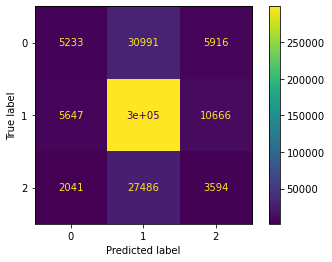

In [43]:
ConfusionMatrixDisplay.from_predictions(data.y_val, y_pred)

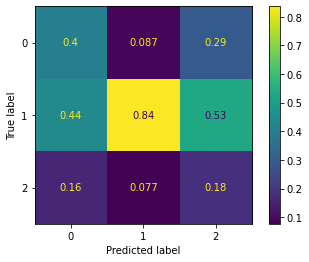

In [44]:
ConfusionMatrixDisplay.from_predictions(data.y_val, y_pred, normalize="pred")

In [45]:
balanced_accuracy_score(data.y_val, y_pred)

0.3936392356629293

In [46]:
np.sum(y_pred) / len(y_pred)

1.018586503457269

In [47]:
y_trivial = np.zeros_like(data.y_val)

In [48]:
accuracy_score(data.y_val, y_trivial)

0.10795799527075323

In [49]:
accuracy_score(data.y_val, y_pred)

0.7880113850339578

In [50]:
balanced_accuracy_score(data.y_val, y_trivial)

0.3333333333333333